# **Renewables Scenario Generation GAN**

Unofficial implementation in Tensorflow 2.

Y. Chen, Y. Wang, D. Kirschen and B. Zhang, "Model-Free Renewable Scenario Generation Using Generative Adversarial Networks," in IEEE Transactions on Power Systems, vol. 33, no. 3, pp. 3265-3275, May 2018, doi: 10.1109/TPWRS.2018.2794541

Notebook Author: https://github.com/haufjan

### **Import**

In [33]:
import time
import os
import csv
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import scipy
from scipy import signal

### **Random Seeds**

In [34]:
np.random.seed(42)

### **Functions**

In [36]:
#Define function for loading wind data
def load_wind_data(path_data: str, path_labels: str) -> tuple:
    """
    Load and preprocess wind data and labels for GAN training
    """
    #Example dataset created for evnet_based GANs wind scenarios generation
    # Data from NREL wind integrated datasets
    with open(f'{path_data}' if path_data.endswith('csv') else f'{path_data}.csv', 'r') as csvfile:
        rows = np.array([row for row in csv.reader(csvfile)], dtype=float)
    trX = []
    m = np.ndarray.max(rows)
    print('\nMax(Wind)', m)

    for x in range(rows.shape[1]):
        train = rows[:-288, x].reshape(-1, 576)
        train = train / m

        trX.extend(train)

    trX = np.asarray(trX)
    print('\nShape TrX', trX.shape)

    with open(f'{path_labels}' if path_labels.endswith('csv') else f'{path_labels}.csv', 'r') as csvfile:
        label = np.array([row for row in csv.reader(csvfile)], dtype=int)
    print('\nShape Label', label.shape)

    return trX, label, m

In [37]:
#Define One-Hot encoding function
def OneHot(X, n: int, negative_class: float = 0.0):
    """
    Function for encoding ordinal labels into OneHot representation
    """
    X = np.asarray(X).flatten()
    if n is None:
        n = np.max(X) + 1
    Xoh = np.ones((len(X), n)) * negative_class
    for i in range(len(X)):
        m = X[i]
        Xoh[i,m] = 1
    return Xoh

### **Load Data**

In [38]:
#Load and preprocess the data and labels
trX, trY, m = load_wind_data(os.path.join('wind.csv'), os.path.join('wind_label.csv'))

#Find number of unique ordinal labels
events_num = len(np.unique(trY))


Max(Wind) 16.0

Shape TrX (9464, 576)

Shape Label (9464, 1)


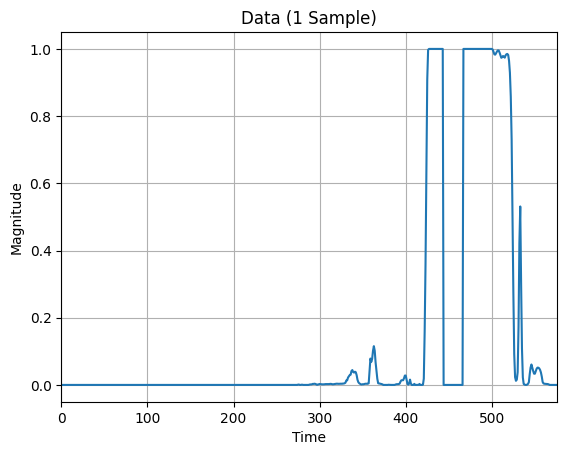

In [39]:
#Plot one sample from the data
fig, ax = plt.subplots()
ax.plot(trX[0,:])
ax.set_xlim(0, trX.shape[-1])
ax.set_xlabel('Time')
ax.set_ylabel('Magnitude')
ax.set_title('Data (1 Sample)')
ax.grid(True)

### **Networks**

##### **Generator**

In [40]:
class Generator(keras.Model):
    def __init__(self, batch_size, dim_y, dim_z, dim_W1, dim_W2, dim_W3, dim_channel, initializer):
        super().__init__(name='Generator')

        #Parameters
        self.batch_size = batch_size
        self.dim_y = dim_y
        self.dim_z = dim_z
        self.dim_W1 = dim_W1
        self.dim_W2 = dim_W2
        self.dim_W3 = dim_W3
        self.dim_channel = dim_channel

        #Layers
        self.layer1_dense = keras.layers.Dense(units=dim_W1,
                                               use_bias=False,
                                               kernel_initializer=initializer)
        self.layer1_batchnorm = keras.layers.BatchNormalization(epsilon=1e-8,
                                                                beta_initializer=initializer,
                                                                gamma_initializer=initializer)
        self.layer1_activation = keras.layers.ReLU()

        self.layer2_dense = keras.layers.Dense(units=dim_W2*6*6,
                                               use_bias=False,
                                               kernel_initializer=initializer)
        self.layer2_batchnorm = keras.layers.BatchNormalization(epsilon=1e-8,
                                                                beta_initializer=initializer,
                                                                gamma_initializer=initializer)
        self.layer2_activation = keras.layers.ReLU()

        self.layer3_conv = keras.layers.Conv2DTranspose(filters=dim_W3,
                                                        kernel_size=5,
                                                        strides=(2,2),
                                                        padding='same',
                                                        kernel_initializer=initializer,
                                                        bias_initializer=initializer)
        self.layer3_batchnorm = keras.layers.BatchNormalization(epsilon=1e-8,
                                                                beta_initializer=initializer,
                                                                gamma_initializer=initializer)
        self.layer3_activation = keras.layers.ReLU()

        self.layer4_conv = keras.layers.Conv2DTranspose(filters=dim_channel,
                                                        kernel_size=5,
                                                        strides=(2,2),
                                                        padding='same',
                                                        kernel_initializer=initializer,
                                                        bias_initializer=initializer)
        self.layer4_batchnorm = keras.layers.BatchNormalization(epsilon=1e-8,
                                                                beta_initializer=initializer,
                                                                gamma_initializer=initializer)

    def call(self, z, y, training: bool = True):
        yb = tf.reshape(y, [self.batch_size, 1, 1, self.dim_y])
        z = tf.concat([z, y], -1)
        h1 = self.layer1_activation(self.layer1_batchnorm(self.layer1_dense(z), training=training))
        h1 = tf.concat([h1, y], -1)
        h2 = self.layer2_activation(self.layer2_batchnorm(self.layer2_dense(h1), training=training))
        h2 = tf.reshape(h2, [self.batch_size, 6, 6, self.dim_W2])
        h2 = tf.concat([h2, yb*tf.ones([self.batch_size, 6, 6, self.dim_y])], -1)
        h3 = self.layer3_activation(self.layer3_batchnorm(self.layer3_conv(h2), training=training))
        h3 = tf.concat([h3, yb*tf.ones([self.batch_size, 12, 12, self.dim_y])], -1)
        h4 = self.layer4_batchnorm(self.layer4_conv(h3), training=training)

        return h4

##### **Discriminator**

In [41]:
class Discriminator(keras.Model):
    def __init__(self, batch_size, dim_y, dim_z, dim_W1, dim_W2, dim_W3, dim_channel, initializer):
        super().__init__(name='Discriminator')

        #Parameters
        self.batch_size = batch_size
        self.dim_y = dim_y
        self.dim_z = dim_z
        self.dim_W1 = dim_W1
        self.dim_W2 = dim_W2
        self.dim_W3 = dim_W3
        self.dim_channel = dim_channel

        #Layers
        self.layer1_conv = keras.layers.Conv2D(filters=dim_W3,
                                               kernel_size=5,
                                               strides=(2,2),
                                               padding='same',
                                               kernel_initializer=initializer,
                                               bias_initializer=initializer)
        self.layer1_activation = keras.layers.LeakyReLU(negative_slope=0.2)

        self.layer2_conv = keras.layers.Conv2D(filters=dim_W2,
                                               kernel_size=5,
                                               strides=(2,2),
                                               padding='same',
                                               kernel_initializer=initializer,
                                               bias_initializer=initializer)
        self.layer2_batchnorm = keras.layers.BatchNormalization(epsilon=1e-8,
                                                                beta_initializer=initializer,
                                                                gamma_initializer=initializer)
        self.layer2_activation = keras.layers.LeakyReLU(negative_slope=0.2)

        self.layer3_dense = keras.layers.Dense(units=dim_W1,
                                               use_bias=False,
                                               kernel_initializer=initializer)
        self.layer3_batchnorm = keras.layers.BatchNormalization(epsilon=1e-8,
                                                                beta_initializer=initializer,
                                                                gamma_initializer=initializer)
        self.layer3_activation = keras.layers.LeakyReLU(negative_slope=0.2)

    def call(self, image, y, training: bool = True):
        yb = tf.reshape(y, [self.batch_size, 1, 1, self.dim_y])
        x = tf.concat([image, yb*tf.ones([self.batch_size, 24, 24, self.dim_y])], -1)
        h1 = self.layer1_activation(self.layer1_conv(x))
        h1 = tf.concat([h1, yb*tf.ones([self.batch_size, 12, 12, self.dim_y])], -1)
        h2 = self.layer2_activation(self.layer2_batchnorm(self.layer2_conv(h1), training=training))
        h2 = tf.reshape(h2, [self.batch_size, -1])
        h2 = tf.concat([h2, y], -1)
        h3 = self.layer3_activation(self.layer3_batchnorm(self.layer3_dense(h2), training=training))

        return h3

### **Loss Functions**

In [42]:
@tf.function
def generator_cost(raw_gen2):
    return -tf.math.reduce_mean(raw_gen2)

In [43]:
@tf.function
def discriminator_cost(raw_real2, raw_gen2):
    return tf.math.reduce_sum(raw_gen2) - tf.math.reduce_sum(raw_real2)

### **GAN**

In [44]:
class GAN():
    def __init__(self,
                 epochs: int = 1000,
                 batch_size: int = 32,
                 image_shape: list = [24, 24, 1],
                 dim_y: int = 6,
                 dim_z: int = 100,
                 dim_W1:int = 1024,
                 dim_W2: int = 128,
                 dim_W3: int = 64,
                 dim_channel: int = 1,
                 learning_rate: float = 1e-4):

        #Parameters
        self.epochs = epochs
        self.batch_size = batch_size
        self.image_shape = image_shape
        self.dim_y = dim_y
        self.dim_z = dim_z
        self.dim_W1 = dim_W1
        self.dim_W2 = dim_W2
        self.dim_W3 = dim_W3
        self.dim_channel = dim_channel
        self.learning_rate = learning_rate
        self.normal = (0, 0.1)

        #Initialization of weights
        initializer = keras.initializers.RandomNormal(mean=0.0, stddev=0.02, seed=42)

        #Instantiate generator and discriminator network
        self.generator = Generator(batch_size, dim_y, dim_z, dim_W1, dim_W2, dim_W3, dim_channel, initializer)
        self.discriminator = Discriminator(batch_size, dim_y, dim_z, dim_W1, dim_W2, dim_W3, dim_channel, initializer)

        #Optimizers
        self.optimizer_g = keras.optimizers.RMSprop(learning_rate=learning_rate)
        self.optimizer_d = keras.optimizers.RMSprop(learning_rate=learning_rate)

        #Loss functions
        self.generator_loss = generator_cost
        self.discriminator_loss = discriminator_cost

        #Auxiliary
        self.fitting_time = None

    def fit(self, x, y):
        self.fitting_time = time.time()
        iterations = 0

        #Control balance of training discriminator vs generator; default k = 4
        k = 4

        #Define generator train step
        @tf.function
        def train_step_g(xs, ys, zs):
            with tf.GradientTape() as tape:
                h4 = self.generator(zs, ys)
                image_gen = keras.ops.sigmoid(h4)
                raw_gen2 = self.discriminator(image_gen, ys)
                p_gen_val = tf.math.reduce_mean(raw_gen2)

                gen_loss_val = self.generator_loss(raw_gen2)

                raw_real2 = self.discriminator(xs, ys)
                p_real_val = tf.math.reduce_mean(raw_real2)

                discrim_loss_val = self.discriminator_loss(raw_real2, raw_gen2)

            grad_g = tape.gradient(gen_loss_val, self.generator.trainable_variables)
            self.optimizer_g.apply_gradients(zip(grad_g, self.generator.trainable_variables))

            return p_gen_val, p_real_val, discrim_loss_val, gen_loss_val

        #Define discriminator train step
        @tf.function
        def train_step_d(xs, ys, zs):
            with tf.GradientTape() as tape:
                h4 = self.generator(zs, ys)
                image_gen = keras.ops.sigmoid(h4)
                raw_gen2 = self.discriminator(image_gen, ys)
                p_gen_val = tf.math.reduce_mean(raw_gen2)

                gen_loss_val = self.generator_loss(raw_gen2)

                raw_real2 = self.discriminator(xs, ys)
                p_real_val = tf.math.reduce_mean(raw_real2)

                discrim_loss_val = self.discriminator_loss(raw_real2, raw_gen2)

            grad_d = tape.gradient(discrim_loss_val, self.discriminator.trainable_variables)
            self.optimizer_d.apply_gradients(zip(grad_d, self.discriminator.trainable_variables))

            return p_gen_val, p_real_val, discrim_loss_val, gen_loss_val

        p_real = []
        p_fake = []
        discrim_loss = []
        gen_loss = []

        #Transform labels into OneHot-representation
        y_oh = OneHot(y, n=self.dim_y)

        for epoch in range(self.epochs):
            if (epoch + 1) % (0.1*self.epochs) == 0:
                print('Epoch:', epoch + 1)

            # index = np.arange(len(y))
            # np.random.shuffle(index)
            # x = x[index]
            # y = y[index]
            # y2 = OneHot(y, n=self.dim_y)

            # for start, end in zip(range(0, len(y), self.batch_size), range(self.batch_size, len(y), self.batch_size)):
            #     xs = x [start:end].reshape([-1, 24, 24, 1]).astype(np.float32)
            #     ys = y2[start:end].astype(np.float32)

            #     zs = np.random.normal(self.normal[0], self.normal[1], size=(self.batch_size, self.dim_z)).astype(np.float32)

            z = np.random.normal(self.normal[0], self.normal[1], size=(len(y), self.dim_z))

            ds_train = tf.data.Dataset.from_tensor_slices((x.astype(np.float32),
                                                           y_oh.astype(np.float32),
                                                           z.astype(np.float32))).cache().shuffle(buffer_size=len(y))

            for xs, ys, zs in ds_train.batch(self.batch_size, drop_remainder=True).prefetch(tf.data.AUTOTUNE):
                xs = tf.reshape(xs, [-1, 24, 24, 1])

                if iterations % k == 0:
                    p_gen_val, p_real_val, discrim_loss_val, gen_loss_val = train_step_g(xs, ys, zs)
                else:
                    p_gen_val, p_real_val, discrim_loss_val, gen_loss_val = train_step_d(xs, ys, zs)

                p_fake.append(p_gen_val)
                p_real.append(p_real_val)
                discrim_loss.append(discrim_loss_val)
                gen_loss.append(gen_loss_val)

                if iterations % 1000 == 0:
                    print('Iterations',
                          iterations,
                          '| Average P(real):', f'{p_real_val:12.9f}',
                          '| Average P(fake):', f'{p_gen_val:12.9f}',
                          '| Discriminator loss:', f'{discrim_loss_val:12.9f}',
                          '| Generator loss:', f'{gen_loss_val:12.9f}')

                iterations += 1

        self.fitting_time = np.round(time.time() - self.fitting_time, 3)
        print('\nElapsed Training Time:', time.strftime('%Hh %Mmin %Ss', time.gmtime(self.fitting_time)), '\n')

        #Plotting
        fig, ax = plt.subplots()
        ax.plot(p_real, label='real')
        ax.plot(p_fake, label='fake')
        ax.legend()
        ax.set_xlim(0, len(p_real))
        ax.set_xlabel('Iteration')
        ax.set_ylabel('Wasserstein Distance')
        ax.grid(True)
        fig.show()

        fig, ax = plt.subplots()
        ax.plot(discrim_loss)
        ax.set_xlim(0, len(discrim_loss))
        ax.set_xlabel('Iteration')
        ax.set_ylabel('Discriminator Loss')
        ax.grid(True)
        fig.show()

    def predict(self):
        #Define generate step
        @tf.function
        def generate_step(zs, y_np_sample):
            return keras.ops.sigmoid(self.generator(zs, y_np_sample, training=False))

        generated_labels = np.random.randint(self.dim_y, size=(self.batch_size,))
        y_np_sample = OneHot(generated_labels, n=self.dim_y)
        zs = np.random.normal(self.normal[0], self.normal[1], size=(self.batch_size, self.dim_z))

        ds_generate = tf.data.Dataset.from_tensor_slices((zs.astype(np.float32),
                                                          y_np_sample.astype(np.float32))).cache()

        for zs, y_np_sample in ds_generate.batch(len(zs)).prefetch(tf.data.AUTOTUNE):
            generated_samples = generate_step(zs, y_np_sample)

        #Inverse transform from image shape (24x24 = 576) into time series
        generated_samples = np.reshape(generated_samples.numpy(), (-1, 576))

        return generated_samples, generated_labels

### **GPU-Accelerator**

In [45]:
if tf.config.list_physical_devices('GPU'):
    print(tf.config.list_physical_devices('GPU'))
    tf.config.set_soft_device_placement(True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### **Instantiate GAN Model**

In [46]:
#Create GAN model instance with specified parameters
gan_model = GAN(epochs=300,
                learning_rate=1e-3,
                dim_y=events_num)

### **Train GAN Model**

Iterations 0 | Average P(real):  0.007787273 | Average P(fake):  0.007782767 | Discriminator loss: -0.147674561 | Generator loss: -0.007782767
Iterations 1000 | Average P(real):  0.195956871 | Average P(fake):  0.110281922 | Discriminator loss: -2807.396728516 | Generator loss: -0.110281922
Iterations 2000 | Average P(real):  0.392341971 | Average P(fake):  0.180746019 | Discriminator loss: -6933.576171875 | Generator loss: -0.180746019
Iterations 3000 | Average P(real):  0.577220440 | Average P(fake):  0.287886292 | Discriminator loss: -9480.901367188 | Generator loss: -0.287886292
Iterations 4000 | Average P(real):  0.767744184 | Average P(fake):  0.388230741 | Discriminator loss: -12435.896484375 | Generator loss: -0.388230741
Iterations 5000 | Average P(real):  0.874366462 | Average P(fake):  0.514452338 | Discriminator loss: -11793.666015625 | Generator loss: -0.514452338
Iterations 6000 | Average P(real):  1.137241840 | Average P(fake):  0.537469268 | Discriminator loss: -19653.3

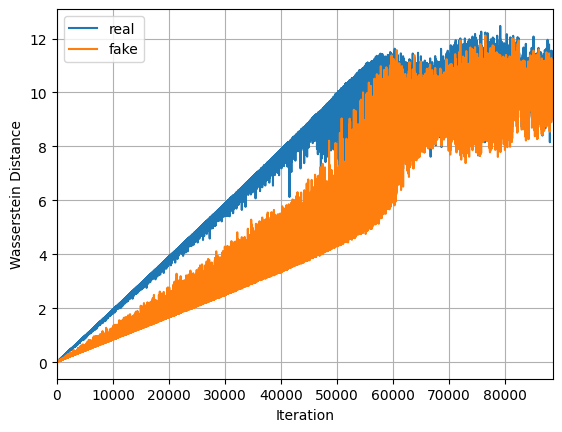

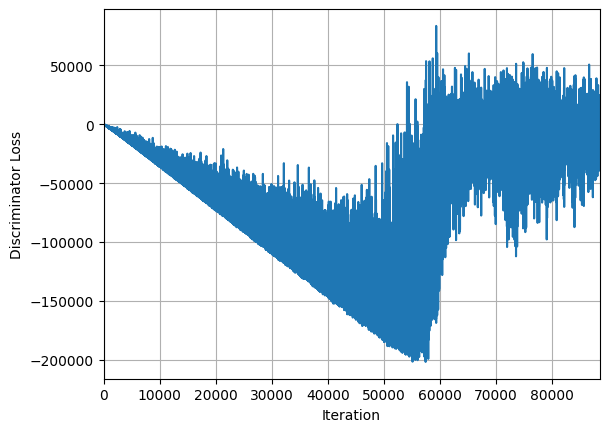

In [47]:
#Start training
gan_model.fit(trX, trY)

### **Generate Data**

In [48]:
#Sample a set of labels and generate data
data_gen, labels_sampled = gan_model.predict()

#Rescaling
data_real = trX*m
data_gen = data_gen*m

### **Evaluation**

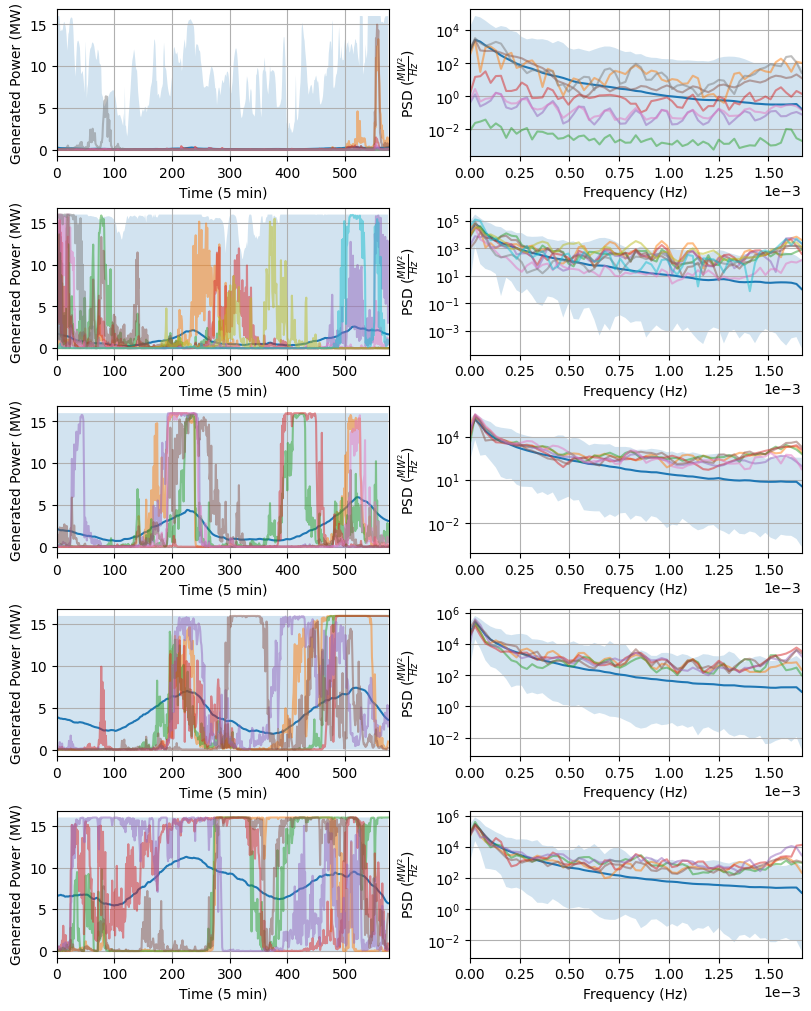

In [52]:
#Find unique ordinal labels within samples
labels_unique = np.unique(labels_sampled)

#Sampling frequency of 5 min resolution in Hz
fs = 1/(60*5)

fig, ax = plt.subplots(len(labels_unique), 2, figsize=(8, 2*len(labels_unique)), layout='constrained')
for i, label in enumerate(labels_unique):
    #Get indices to organize by ordinal labels
    indices_real, _ = np.where(trY == label)
    indices_gen = np.where(labels_sampled == label)

    #Left column
    ax[i,0].fill_between(np.arange(0, data_real.shape[-1]), np.max(data_real[indices_real], 0), np.min(data_real[indices_real], 0), alpha=0.2)
    ax[i,0].plot(np.mean(data_real[indices_real], 0))
    ax[i,0].plot(data_gen[indices_gen].transpose(), alpha=0.5)
    ax[i,0].set_xlabel('Time (5 min)')
    ax[i,0].set_ylabel('Generated Power (MW)')
    ax[i,0].set_xlim(0,data_gen.shape[-1])
    ax[i,0].grid(True)

    #Right column
    f_real, Pxx_den_real = signal.welch(data_real[indices_real,:], fs, nperseg=128)
    f_gen, Pxx_den_gen = signal.welch(data_gen[indices_gen[0],:], fs, nperseg=128)
    ax[i,1].semilogy(f_real, np.mean(Pxx_den_real, 0))
    ax[i,1].fill_between(f_real, np.max(Pxx_den_real, 0), np.min(Pxx_den_real, 0), alpha=0.2)
    ax[i,1].semilogy(f_gen, Pxx_den_gen.transpose(), alpha=0.5)
    ax[i,1].set_xlim(0,max(f_real))
    ax[i,1].ticklabel_format(axis='x', style='sci', scilimits=(0,max(f_real)))
    ax[i,1].set_xlabel('Frequency (Hz)')
    ax[i,1].set_ylabel(r'PSD ($\frac{MW^2}{Hz}$)')
    ax[i,1].grid(True)

# fig.savefig('generated_data.png', bbox_inches='tight')